<a href="https://colab.research.google.com/github/KadenC2026/Enviornment-Setup/blob/main/NeuralNetworkVaR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/50, Loss: 0.0012
Epoch 2/50, Loss: 0.0006
Epoch 3/50, Loss: 0.0007
Epoch 4/50, Loss: 0.0008
Epoch 5/50, Loss: 0.0009
Epoch 6/50, Loss: 0.0009
Epoch 7/50, Loss: 0.0010
Epoch 8/50, Loss: 0.0009
Epoch 9/50, Loss: 0.0009
Epoch 10/50, Loss: 0.0009
Epoch 11/50, Loss: 0.0008
Epoch 12/50, Loss: 0.0008
Epoch 13/50, Loss: 0.0007
Epoch 14/50, Loss: 0.0007
Epoch 15/50, Loss: 0.0006
Epoch 16/50, Loss: 0.0006
Epoch 17/50, Loss: 0.0006
Epoch 18/50, Loss: 0.0007
Epoch 19/50, Loss: 0.0007
Epoch 20/50, Loss: 0.0006
Epoch 21/50, Loss: 0.0006
Epoch 22/50, Loss: 0.0006
Epoch 23/50, Loss: 0.0006
Epoch 24/50, Loss: 0.0006
Epoch 25/50, Loss: 0.0006
Epoch 26/50, Loss: 0.0006
Epoch 27/50, Loss: 0.0006
Epoch 28/50, Loss: 0.0006
Epoch 29/50, Loss: 0.0006
Epoch 30/50, Loss: 0.0006
Epoch 31/50, Loss: 0.0006
Epoch 32/50, Loss: 0.0006
Epoch 33/50, Loss: 0.0006
Epoch 34/50, Loss: 0.0006
Epoch 35/50, Loss: 0.0006
Epoch 36/50, Loss: 0.0006
Epoch 37/50, Loss: 0.0006
Epoch 38/50, Loss: 0.0006
Epoch 39/50, Loss: 0.

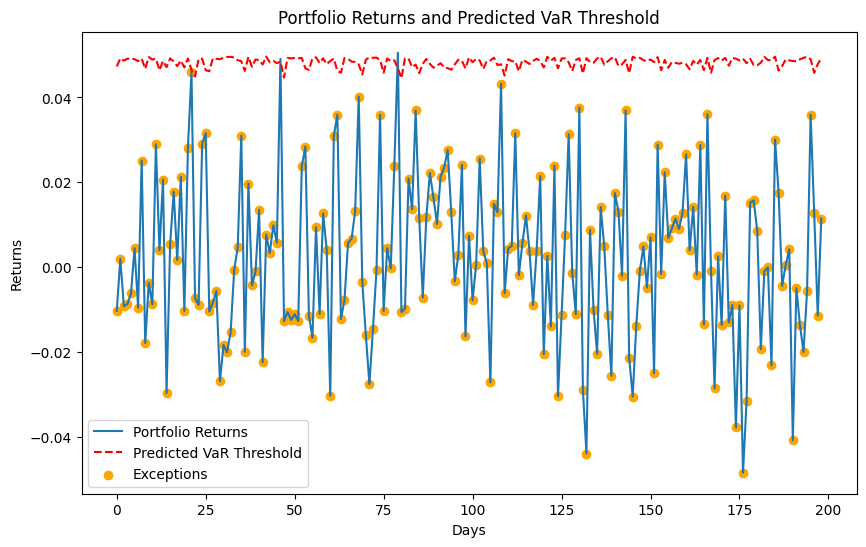

In [1]:
# import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------
# 1. Data Setup
# ----------------------------------------------

# Simulate portfolio returns
np.random.seed(42). # Fixes NumPy’s random number generator
returns = np.random.normal(0, 0.02, 1000)  # Draws 1 000 samples from a Normal distribution with mean 0 and standard deviation 0.02

# Split data into training and testing sets
train_size = int(0.8 * len(returns)) # 80% of data is used for training
train_returns = returns[:train_size]
test_returns = returns[train_size:] # 20% of data is used for testing

# Prepare input features (lagged returns)
X_train = torch.tensor(train_returns[:-1], dtype=torch.float32).unsqueeze(1) # all but the last element,” so an array of length 799.
y_train = torch.tensor(train_returns[1:], dtype=torch.float32).unsqueeze(1) # all but the first element,” also length 799. So each index of y_train is each the next day’s return of the corresponding index of x_train.
X_test = torch.tensor(test_returns[:-1], dtype=torch.float32).unsqueeze(1) # Do the same thing as above for testing data
y_test = torch.tensor(test_returns[1:], dtype=torch.float32).unsqueeze(1)

# ----------------------------------------------
# 2. Neural Network for Quantile Regression
# ----------------------------------------------

class QuantileNN(nn.Module):
    def __init__(self):
        super(QuantileNN, self).__init__()
        self.fc1 = nn.Linear(1, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Custom quantile loss function
def quantile_loss(y_pred, y_true, quantile):
    error = y_true - y_pred #calculate error
    return torch.mean(torch.max(quantile * error, (quantile - 1) * error))
    # If error is positive (actual > predicted), this term is $\tau (y - \hat y)$
    # If the error is negative (actual < predicted), this term is $(\tau - 1)(y - \hat y)$. Note that $\tau - 1$ is negative when $\tau < 1$, flipping the sign.

# Define confidence level
confidence_level = 0.99

# Initialize model, optimizer, and loss function
model = QuantileNN() # 99% quantile (i.e. 1% worst‐case losses).
optimizer = optim.Adam(model.parameters(), lr=0.001) # Use Adam Algorithm with learning rate of 0.001?

# ----------------------------------------------
# 3. Model Training
# ----------------------------------------------

# Training loop
epochs = 50 # We’ll pass through the training data 50 times.
batch_size = 32
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_pred = model(X_train)

    # Compute loss
    loss = quantile_loss(y_pred, y_train, confidence_level)
    losses.append(loss.item())

    # Backward pass and optimization
    loss.backward() #$\displaystyle \frac{\partial\;\mathrm{loss}}{\partial \theta}\quad\text{for every parameter }\theta.$
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

# ----------------------------------------------
# 4. VaR Estimation
# ----------------------------------------------

# Predict VaR for test data
model.eval()
with torch.no_grad():
    predicted_var = model(X_test).squeeze()

# Count exceptions (days where losses exceed VaR)
exceptions = y_test.squeeze() < predicted_var
num_exceptions = torch.sum(exceptions).item()

print(f"Number of Exceptions: {num_exceptions}")

# ----------------------------------------------
# 5. Visualization
# ----------------------------------------------

# Plot returns and predicted VaR threshold
plt.figure(figsize=(10, 6))
plt.plot(y_test.squeeze().numpy(), label="Portfolio Returns")
plt.plot(predicted_var.numpy(), color="red", linestyle="--", label="Predicted VaR Threshold")
plt.scatter(np.where(exceptions.numpy())[0], y_test.squeeze().numpy()[exceptions.numpy()], color="orange", label="Exceptions")
plt.xlabel("Days")
plt.ylabel("Returns")
plt.title("Portfolio Returns and Predicted VaR Threshold")
plt.legend()
plt.show()